In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

from sklearn.mixture import GaussianMixture

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

2022-07-26 13:22:57.462466: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
n = 8
n_node = 3

In [3]:
K = tc.set_backend('jax')

In [4]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
mean = jnp.mean(x_train, axis=0)
x_train = x_train - mean


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = y == a
    return x, y

In [5]:
def loss(params, x, y, k, out):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = (jnp.real(c.expectation([tc.gates.z(), [out,]])) + 1) / 2
    return -(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
loss = K.jit(loss, static_argnums=[3, 4])

In [6]:
def accuracy(params, x, y, k, out):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [out,]])) + 1) / 2)
    return y_pred == y
accuracy = K.jit(accuracy, static_argnums=[3, 4])

In [7]:
k = 6

In [8]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

In [9]:
params_list = []
gmm_list = []
for node in tqdm(range(n_node)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    data = tf.data.Dataset.from_tensor_slices((x_train_small, y_train_node)).shuffle(100).batch(128)

    # GMM
    gmm = GaussianMixture(n_components=5, max_iter=100)
    gmm.fit(x_train_small)
    gmm_list.append(gmm)

    params = K.randn((k * 2, n), dtype=jnp.float32)
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)

    loss_list = []
    acc_list = []
    for e in tqdm(range(2)):
        for i, (x, y) in enumerate(data):
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params, x, y, k, node)
            updates, opt_state = opt.update(grad_val, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss_mean = jnp.mean(loss_val)
            if i % 30 == 0:
                acc = jnp.mean(compute_accuracy(params, x, y, k, node))
                acc_list.append(acc)
                loss_list.append(loss_mean)
                print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

    plt.plot(loss_list)
    plt.plot(acc_list)
    plt.legend(['loss', 'accuracy'])
    plt.ylim(0, 1)
    plt.show()

    params_list.append(params)


  0%|          | 0/3 [00:00<?, ?it/s]

2022-07-20 11:58:06.830664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 11:58:09.468776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30173 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:12:00.0, compute capability: 7.0


  0%|          | 0/2 [00:00<?, ?it/s]

: 

: 

In [54]:
def pred(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2)
    return y_pred
pred = K.jit(pred, static_argnums=[3])

In [55]:
density_est_list = []
p_node = []
for node in tqdm(range(n_node)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    # x_train_node = x_train_node[:1000]
    # y_train_node = y_train_node[:1000]
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    dm = jnp.einsum('nij, njk -> nik', jnp.conjugate(x_train_small.reshape(-1, 2**n, 1)), x_train_small.reshape(-1, 1, 2**n))
    density_est_list.append(jnp.mean(dm, axis=0))
    p_node.append(len(x_train_small))
density_est_list = jnp.stack(density_est_list, axis=0)
p_node = jnp.stack(p_node, axis=0) / jnp.sum(jnp.array(p_node))

  0%|          | 0/3 [00:00<?, ?it/s]

In [56]:
p_node

DeviceArray([0.34603825, 0.32461748, 0.32934427], dtype=float32)

In [100]:
def pred_comb_with_gmm(params, x, gmm_scores, k):
    dm_list = []
    for node in range(n_node):
        c = tc.Circuit(n, inputs=x)
        for j in range(k):
            for i in range(n - 1):
                c.cnot(i, i + 1)
            for i in range(n):
                c.rx(i, theta=params[node][2 * j, i])
                c.ry(i, theta=params[node][2 * j + 1, i])
        density_matrix = jnp.conjugate(c.wavefunction('ket')) @ c.wavefunction('bra')
        dm_list.append(density_matrix)

    #     projector = jnp.conjugate(x.reshape(-1, 1)) @ x.reshape(1, -1)
    #     weight = jnp.einsum('nij, ji -> n', density_est_list, projector).reshape(-1, 1, 1) * p_node.reshape(-1, 1, 1)
    #     weight = weight
    #     weight = weight / jnp.sum(weight)

    weight = jnp.exp(gmm_scores - jnp.max(gmm_scores)).reshape(-1) * p_node
    weight = weight / jnp.sum(weight)

    # dm = jnp.sum(jnp.stack(dm_list, axis=0) * weight, axis=0)
    # # print(jnp.trace(dm))
    # c = tc.DMCircuit(n, dminputs=dm)
    # pred_prob = []
    # for node in range(6):
    #     pred_prob.append((jnp.real(c.expectation([tc.gates.z(), [node,]])) + 1) / 2)

    pred_prob = []
    for node in range(n_node):
        c = tc.DMCircuit(n, dminputs=dm_list[node])
        pred_prob.append(1-(jnp.real(c.expectation([tc.gates.z(), [node,]])) + 1) / 2)

    # print(pred_prob)
    # print(weight)
    pred_prob = jnp.stack(pred_prob, axis=0) * weight.reshape(-1)
    pred_prob = jnp.hstack([1-jnp.sum(pred_prob), pred_prob])

    return pred_prob
pred_comb_with_gmm = K.vmap(pred_comb_with_gmm, vectorized_argnums=[1, 2])

def pred_comb(params, x, k):
    gmm_scores_list = []
    for node in range(n_node):
        gmm_scores = gmm_list[node].score_samples(x)
        gmm_scores_list.append(gmm_scores)
    gmm_scores_list = jnp.stack(gmm_scores_list, axis=-1)
    
    pred_prob = pred_comb_with_gmm(params, x, gmm_scores_list, k)
    return pred_prob

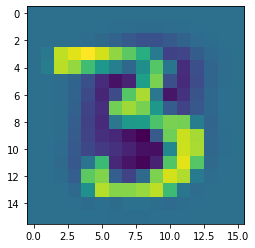

In [105]:
i = 3
x_train_node, y_train_node = filter_pair(x_train, y_train, 0, 2 + 1)
x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
plt.imshow(x_train_small[i].reshape(16, 16))

In [106]:
pred_comb(params_list, x_train_small[i].reshape(1, -1), k)

DeviceArray([[0.3073452, 0.       , 0.       , 0.6926548]], dtype=float32)

In [109]:
jnp.mean(jnp.argmax(pred_comb(params_list, x_train_small, k), axis=-1)==(1-y_train_node[:1000])*3)